## <font color= grey > Profitability Maximization via Google, Apple and GE  Stock Options  </font>

### <font color= grey >Project Introduction </font>  
##### The goal of this analysis is the maximization of investment return via stock options. Assuming an investment amount of 1 million USD, the user will be able to explore code that finds historical market and stock prices, forecasts those prices forward via a user-defined future time frame, and then selects the best mix of options to maximize profit.

##### The analysis will be done in 3 sequential parts:
1. Predict future stock market movement in a user-defined future timeframe  [section C]
2. Mirror the market's movement using each stocks' beta and estimate the respective stock prices at the end of the given timeframe  [section C]
3. Value the stock options based on the forecasted stock prices and create the optimal portfolio to maximize profit  [section D]                                                                                                                            
                                                                                                                                 
                                                                                                           
###### * Please note that user assumptions and input are needed for:                                                                                           
a. Current month and option expiration month [code block 2]                                                     
b. Date to start the market simulation [code block 10]

### <font color= grey > >>> Code Block Summary <<< </font> 

##### A. Package Upload and User Time-Frame Definitions
Code block 1. Package upload | Uploading packages for data handling, data visualization, web-scraping, and math programs  
Code block 2. User input to define MODEL SPECS forecasting timeframe and assignment of variable 'M' (number of months)  

##### B. Data Gathering, Scraping, and Formatting in Preparation for Forecast Simulation
Code block 3. Market and stock price import  
Code block 4. Market sigma (used later in forward-looking simulation)   
Code block 5. Treasury rate for risk-free proxy  
Code block 6. Finding each stock's beta  

##### C. Visualization, Market Prediction, and Stock Valuation   
Code block 7. Data visualization of each asset: both price and percentage return  
Code block 8. Predict market movement via simulation for the time-frame chosen in code block 2  
Code block 9. Visualize market movement prediction from previous code block    
Code block 10. Creating dataframe to house future S&P 500 predictions
Code block 11. Use forecasted market movement stock BETA to find forecasted stock price at end of forecast horizon

##### D. Scraping Option Prices, Option Valuation, and Investment Allocation       
Code block 12. Data gathering/scraping to get current option costs at various strike prices  
> 12(a) Google  
> 12(b) Apple  
> 12(c) GE

Code block 13. Select the most profitable options of all 12 possible investment variations --> combine into DF           
Code block 14. Find the optimal investment allocation among the various option choices using Linear Programming (GEKKO package)      
Code block 15. Print final allocations and portfolio performance   

### <font color= grey > >>> A. Package Upload and User Time-Frame Definitions <<< </font>

In [57]:
### Code Block 1 | Package Upload ###
#####################################

# For data storage and manipulation
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

# For visualization
import seaborn as sns # for visualization
%matplotlib inline
import matplotlib.pyplot as plt

# For importing of live and excel sheet investment data
from bs4 import BeautifulSoup

# For mathematical functionality
from mpmath import *
from scipy.optimize import linprog
import math
import numpy.random as npr
from pylab import mpl

In [129]:
### Code Block 2 | User to define forecast timeframe in creation of timeframe for actuals, forecasts, and option expiration ###
###############################################################################################################################

### USER INPUT NEEDED BELOW ###
###############################
# What is the current month and year / what month do we have actuals up until?
current_year = 2020
current_month = 10  # Input number of actual month (1 = Jan, 3 = March, etc)

### USER INPUT NEEDED BELOW ###
###############################
# What date is the option expiration? User can only select June 2020, January 2021, or January 2022 
option_expiration_year = 2023 # User can only select a January or June date within 3 years from current year/month 
option_expiration_month = 1 # Can only select January or June...input number of actual month (1 = Jan, 6 = Jun)

## IMPORTANT STEP --> Assignment of month count to variable 'M' 
if option_expiration_year == current_year:
    M = option_expiration_month - current_month
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)

elif option_expiration_year - current_year == 1:
    M = (option_expiration_month - current_month + 12)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)

elif option_expiration_year - current_year == 2:
    M = (option_expiration_month - current_month + 24)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)
    
elif option_expiration_year - current_year == 3:
    M = (option_expiration_month - current_month + 36)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)
    
else:
    print('Requested dates are outside of scope')

Assuming current mth-yr is 10 - 2020 and option expiration is 1 - 2023 , The forecast will be 27 months in the future. So 'M' =  27


### <font color= grey > >>> B. Data Gathering, Scraping, and Formatting in Preparation for Forecast Simulation <<< </font>

In [130]:
### Code Block 3 | Importing S&P500 and stock info from Alphavantage and combining into dataframe ###
#####################################################################################################

# Pulling historical stock info from AlphaVantage
import requests
import os
import json
from dotenv import load_dotenv

env_file = 'env_vars_ALPHAVANTAGE.env'
load_dotenv(env_file) # this has the AlphaVantage password
myAPIKey = os.getenv('ALPHAVANTAGE_KEY')
print("The Alpha Vantage key is", myAPIKey, "and has been successfully implemented")

## For S&P500 market data
API_URL = "https://www.alphavantage.co/query"
# for S&P500 data 
tickers = ['SPY']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": "myAPIKey" # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    SPY = (data["Monthly Adjusted Time Series"])  # Monthly Adjusted Time Series
    

## For stock 1: Apple
API_URL = "https://www.alphavantage.co/query"
# for Apple data 
tickers = ['AAPL']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    APPLE = (data["Monthly Adjusted Time Series"])  # Monthly Adjusted Time Series

    
## for Stock 2: GE
API_URL = "https://www.alphavantage.co/query"
# for GE data
tickers = ['GE']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    GE = (data["Monthly Adjusted Time Series"])  # Monthly Adjusted Time Series

    
## for Stock #3: Google
API_URL = "https://www.alphavantage.co/query"
# the ticker we are looking up 
tickers = ['GOOGL']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    GOOGLE = (data["Monthly Adjusted Time Series"])  # Monthly Adjusted Time Series
    

# changing each stock's JSON file into a dataframe     
df_SPY = pd.DataFrame(SP500) # turn JSON into a dataframe
df_SPY = df_SPY.transpose() # transpose it
df_SPY = df_SPY['5. adjusted close'] # take only the "adjusted close" column
df_SPY = df_SPY.reset_index(inplace = False) # keeping the month column for S&P500 (we only need it for one of the datasets)

df_APPLE = pd.DataFrame(APPLE) # turn JSON into a dataframe
df_APPLE = df_APPLE.transpose() # transpose it
df_APPLE = df_APPLE['5. adjusted close'] # take only the "adjusted close" column

df_GE = pd.DataFrame(GE) # turn JSON into a dataframe
df_GE = df_GE.transpose() # transpose it
df_GE = df_GE['5. adjusted close'] # take only the "adjusted close" column

df_GOOGLE = pd.DataFrame(GOOGLE) # turn JSON into a dataframe
df_GOOGLE = df_GOOGLE.transpose() # transpose it
df_GOOGLE = df_GOOGLE['5. adjusted close'] # take only the "adjusted close" column


## Checking length of Google, GE, and Apple Dataframes before combining into dataframe

# Checking that all dataframes are the same legnth 
print("Length of SPY data is", len(df_SPY),",",
      "Length of Google data is", len(df_GOOGLE),",", 
      "Length of Apple data is", len(df_APPLE),",", 
      "Length of GE data is", len(df_GE),",")

if len(df_SPY) == len(df_GOOGLE) == len(df_APPLE) == len(df_GE): # ARE ALL DATAFRAMES EQUAL TO EACHOTHER'S LENGTH?
    print("All dataframes are of equal length. You are clear to Merge!")
else:
    print('The dataframes are NOT of equal length...must cut down longer datasets to match the shortest one')
    
    
##### Combining all dates, market, and stock prices into one dataframe #####
############################################################################

# Turning each Dataframe into a numpy array for ease-of-use 
np_GOOGLE = np.array((df_GOOGLE))
np_GE = np.array((df_GE))
np_APPLE = np.array((df_APPLE))

min_length = min(len(df_SPY), len(df_GOOGLE), len(df_APPLE), len(df_GE))

# combining market and stock data into 1 array  
vstacked = np.vstack((df_SPY.iloc[0:min_length, 0], df_SPY.iloc[0:min_length, 1], np_GOOGLE[0:min_length], np_GE[0:min_length], np_APPLE[0:min_length]))

# flipping 
vstacked_data = pd.DataFrame(vstacked).transpose()

# naming columns 
vstacked_data.columns = ['Date', 'SPY', 'Google', 'GE', 'Apple']

# changing data types
vstacked_data['Date'] = pd.to_datetime(vstacked_data['Date'])
vstacked_data['SPY'] = vstacked_data['SPY'].astype(float)
vstacked_data['Google'] = vstacked_data['Google'].astype(float)
vstacked_data['GE'] = vstacked_data['GE'].astype(float)
vstacked_data['Apple'] = vstacked_data['Apple'].astype(float)

# making date the index
vstacked_data = vstacked_data.set_index('Date')

The Alpha Vantage key is SCFN03L8NMSR0FVC and has been successfully implemented
SPY is successfully uploaded
AAPL is successfully uploaded
GE is successfully uploaded
GOOGL is successfully uploaded
Length of SPY data is 252 , Length of Google data is 195 , Length of Apple data is 252 , Length of GE data is 252 ,
The dataframes are NOT of equal length...must cut down longer datasets to match the shortest one


In [131]:
### Code Block 4 | Finding market sigma for prediction model input later ###
############################################################################

## Finding sigma for monthly market returns to plug into the forecasting simulation
market_predict = vstacked_data['SPY']
## The delta of monthly returns should not be confused with the standard deviation of market levels 
monthly_deltas = market_predict.pct_change(-1) # the "-1" reverses the order so that the pct_change reflects delta from previous month to current month
print("Sigma for past", round(len(vstacked_data)/12,2), "years of monthly returns is", round(np.std(monthly_deltas)*100,3),"%") # Sigma of monthly returns (not to be confused with standard deviation of monthly market levels)

Sigma for past 16.25 years of monthly returns is 4.189 %


In [132]:
### Code Block 5 | Finding risk-free interest rate for prediction model input later ###
#######################################################################################

## Finding current risk free rate via a data scrape (risk-free-rate is proxied via month-to-date 1 month treasury yield). This metric 
## was not found on Aplphavantage so a more rudimentary method was used; Beautifulsoup is utilized via the treasury website
## to find the MTD average treasury rate. This rate is then used as a proxy for the risk-free rate.  

from urllib.request import urlopen
urlString='https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield'
url = urlopen(urlString) # open the url
soup = BeautifulSoup(url, 'html.parser') # call soup into action on the URL
t_chart = soup.find(class_="t-chart") # find the main table on the page

date = [] # creating blank list 1 of 2 to house date
One_Mth_Yield = [] # creating blank list 2 of 2 to house risk-free rate
tableRows = t_chart.find_all('tr') # scroll through the table and find rows with 'tr' - which means they have legitimate data
for row in tableRows: # will only occur as many times as dataframe has legitimate data in its rows 
    cells = row.findAll('td') # scroll through the table and find cells with 'td' - which means they have legitimate data
    if (len(cells) > 0): # will only occur as many legitimate cells are in the table
        cell1 = cells[1].text.strip()  # this brings in the 1 month yield found in the second column
        One_Mth_Yield.append(cell1)

riskfree_df = pd.DataFrame({"1mo":One_Mth_Yield}) # creating a dataframe out of the final list
n = riskfree_df.shape[0] # this is how many days are final in the current month
sum_table = []
for i in range(0, n):
    num = float(riskfree_df.iloc[i])
    sum_table.append(num)
sum_table = pd.DataFrame(sum_table)
r = sum_table.mean() # finding average 
riskfree = r[0] # taking just the average and leaving all the excess indexing out of the final number

# this value will be assigned to 'r' below
print("The MTD Risk-Free rate is", round(riskfree, 4), '%')

The MTD Risk-Free rate is 0.09 %


In [133]:
### Code Block 6 | Getting Beta's for all three stocks from Yahoo Finance for prediction model input later ###
##############################################################################################################

# Importing needed packages     
from bs4 import BeautifulSoup
import requests    

## Getting Apple beta measure ##
from urllib.request import urlopen
urlString = 'https://finance.yahoo.com/quote/AAPL?p=AAPL' # take this URL string and make it a variable
url = urlopen(urlString)  # open this URL string and prepare it to be read
soup = BeautifulSoup(url, 'html.parser') # introduce the beautifulsoup tool to the URL we created
table = soup.select_one("table:nth-of-type(2)") # pick the second table on the page
tableBody = table.find('tbody') # find this one label in the site table metadata
tableRows = tableBody.find_all('tr') # find all these labels inside the table body and mark them as rows

measures = []
scores = []
for row in tableRows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
Apple_beta = scores[1]


## Getting GE beta measure ##
from urllib.request import urlopen
urlString = 'https://finance.yahoo.com/quote/GE?p=GE&.tsrc=fin-srch' # take this URL string and make it a variable
url = urlopen(urlString)  # open this URL string and prepare it to be read
soup = BeautifulSoup(url, 'html.parser') # introduce the beautifulsoup tool to the URL we created
table = soup.select_one("table:nth-of-type(2)") # pick the second table on the page
tableBody = table.find('tbody') # find this one label in the site table metadata
tableRows = tableBody.find_all('tr') # find all these labels inside the table body and mark them as rows

measures = []
scores = []
for row in tableRows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
GE_beta = scores[1]


## Getting GOOGLE beta measure ##
from urllib.request import urlopen
urlString = 'https://finance.yahoo.com/quote/GOOG?p=GOOG&.tsrc=fin-srch' # take this URL string and make it a variable
url = urlopen(urlString)  # open this URL string and prepare it to be read
soup = BeautifulSoup(url, 'html.parser') # introduce the beautifulsoup tool to the URL we created
table = soup.select_one("table:nth-of-type(2)") # pick the second table on the page
tableBody = table.find('tbody') # find this one label in the site table metadata
tableRows = tableBody.find_all('tr') # find all these labels inside the table body and mark them as rows

measures = []
scores = []
for row in tableRows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
Google_beta = scores[1]

## Creating a combined dataframe with stock Betas
beta_combine = pd.DataFrame({"Company" : ['Apple', 'GE', 'Google'],
"3YrBeta" :[float(Apple_beta), float(GE_beta), float(Google_beta)]})
beta_combine.set_index('Company') # Making company the index column


##############################################################
## FINAL BETA's of EACH STOCK ##
Apple_beta = beta_combine.iloc[0,1]
GE_beta = beta_combine.iloc[1,1]
Google_beta = beta_combine.iloc[2,1]

print('Google beta is', Google_beta,',', 'Apple beta is', Apple_beta,',', 'GE beta is', GE_beta)

Google beta is 1.02 , Apple beta is 1.35 , GE beta is 0.78


### <font color= grey > >>> C. Visualization, Market Prediction, and Stock Valuation <<< </font>

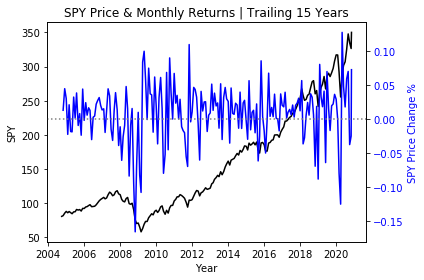

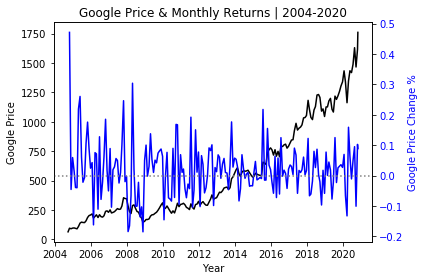

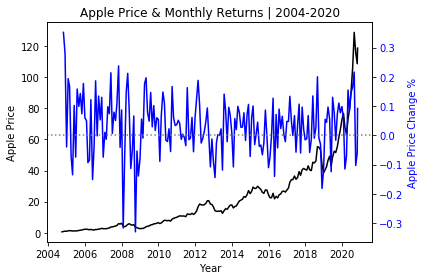

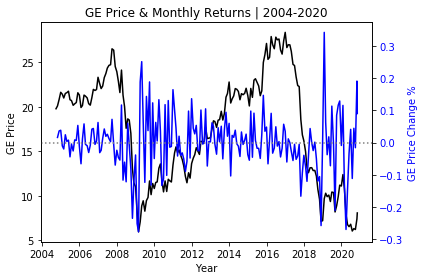

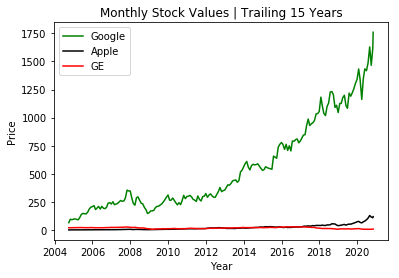

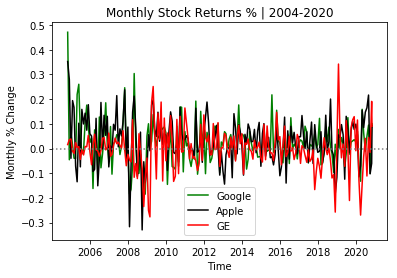

In [122]:
### Code Block 7 | Showing visuals of all assets included in this analysis ###
##############################################################################

# Creating a dataframe to showcase monthly returns for each asset 
SPY_trend = vstacked_data['SPY'].pct_change(-1)
Google_trend = vstacked_data['Google'].pct_change(-1)
GE_trend = vstacked_data['GE'].pct_change(-1)
Apple_trend = vstacked_data['Apple'].pct_change(-1)


# S&P500 MARKET VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('SPY Price & Monthly Returns | Trailing 15 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('SPY', color = 'black')
ax1.plot(vstacked_data['SPY'], color = 'black')
ax1.tick_params(axis='y', labelcolor = 'black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(SP500_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# GOOGLE VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('Google Price & Monthly Returns | 2004-2020')
ax1.set_xlabel('Year')
ax1.set_ylabel('Google Price', color='black')
ax1.plot(vstacked_data['Google'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('Google Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(Google_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# APPLE VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('Apple Price & Monthly Returns | 2004-2020')
ax1.set_xlabel('Year')
ax1.set_ylabel('Apple Price', color='black')
ax1.plot(vstacked_data['Apple'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('Apple Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(Apple_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# GE VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('GE Price & Monthly Returns | 2004-2020')
ax1.set_xlabel('Year')
ax1.set_ylabel('GE Price', color='black')
ax1.plot(vstacked_data['GE'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('GE Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(GE_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# All Stock prices combined onto one graph
fig, ax1 = plt.subplots()
plt.title('Monthly Stock Values | Trailing 15 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price', color = 'black')
ax1.plot(vstacked_data['Google'], color = 'green')
ax1.plot(vstacked_data['Apple'], color = 'black')
ax1.plot(vstacked_data['GE'], color = 'red')
ax1.tick_params(axis='y', labelcolor = 'black')
plt.legend()


# All Stock returns combined onto one graph
fig, ax1 = plt.subplots()
plt.title('Monthly Stock Returns % | 2004-2020')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly % Change')
ax1.plot(Google_trend, color = 'green')
ax1.plot(Apple_trend, color = 'black')
ax1.plot(GE_trend, color = 'red')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax1.tick_params(axis='y', labelcolor = 'black')
plt.legend()

In [134]:
### Code Block 8 | Monthly Market Simulations  ###
##################################################

## These monthly market simulations will be used to come to a final market level and value each stock using the stock's 
## respective beta to the market over the future time interval that the user has chosen above. 

## Setting up parameters before simulation
# the variable 'M' is uqivalent with how many discrete time intervals (i.e. months) we need to forecast into the future
# 'M' has already been created in code box 2 above
I = 10000 # number of simulation (paths) for each month
T = M/12 # horizon in years
dt = T / M # time interval for each step
S = np.zeros((M+1, I)) # define matrix of zeros --> it's 'M+1' because the first row is the starting price of the market  
r = riskfree/100 # risk-free interest rate found above 
sigma = np.std(monthly_deltas) # represets constant volatility of monthly returns
S[0] = vstacked_data['SPY'][0] # setting up starting price

# For each time slice, generate a new price, based on the prior price and r, sigma, dt, and unit normal random numbers
for t in range(1, M+1): 
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * npr.standard_normal(I))
# 'S' represents a vector of normally distributed simulated market returns

Text(0.5,1,'Forecasted S&P500 Pathway Simulations: 100')

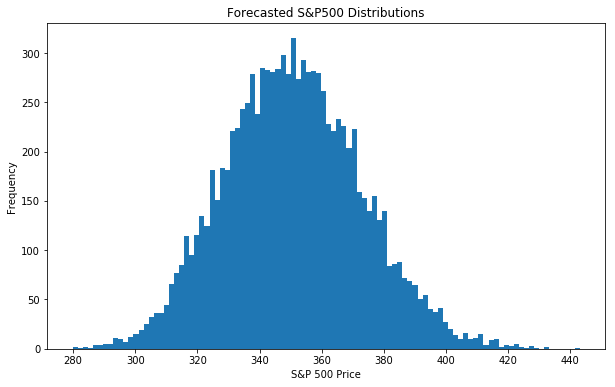

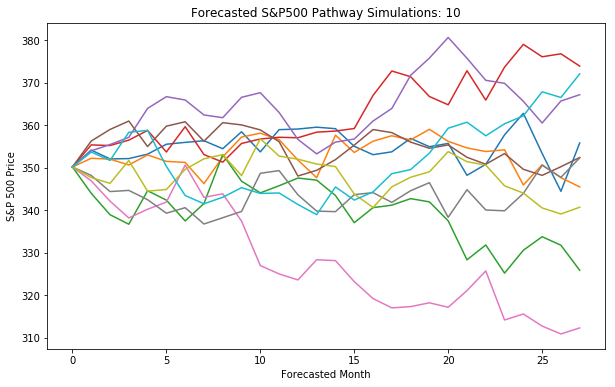

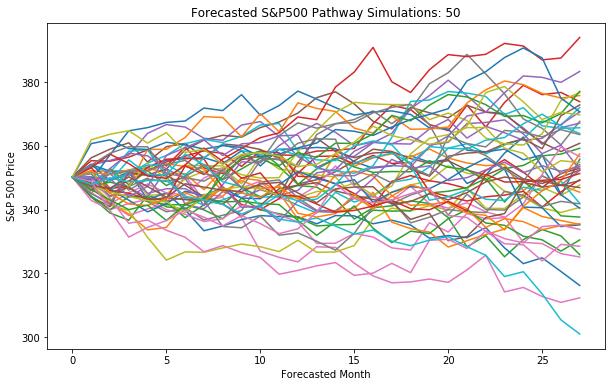

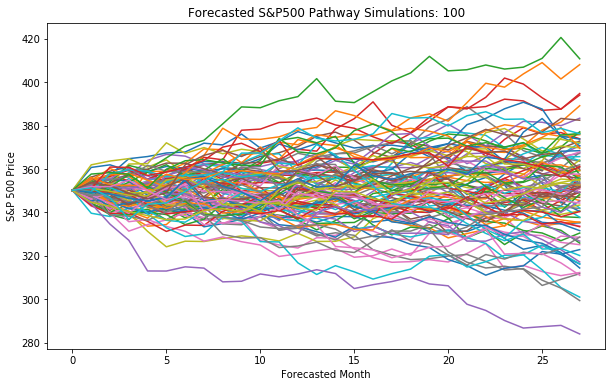

In [135]:
### Code Block 9 | Market Simulation Visualizations ###
#######################################################

# PLot Histogram of Returns
plt.figure(figsize=(10,6))
plt.title('Forecasted S&P500 Distributions')
plt.hist(S[-1], bins=100)
plt.xlabel('S&P 500 Price')
plt.ylabel('Frequency')

# PLot Decision Paths
npathsToPlot = 10
plt.figure(figsize=(10,6))
plt.plot(S[:,:npathsToPlot], lw=1.5)
plt.xlabel('Forecasted Month')
plt.ylabel('S&P 500 Price')
plt.title("Forecasted S&P500 Pathway Simulations: 10")

# PLot Decision Paths
npathsToPlot = 50
plt.figure(figsize=(10,6))
plt.plot(S[:,:npathsToPlot], lw=1.5)
plt.xlabel('Forecasted Month')
plt.ylabel('S&P 500 Price')
plt.title("Forecasted S&P500 Pathway Simulations: 50")

# PLot Decision Paths
npathsToPlot = 100
plt.figure(figsize=(10,6))
plt.plot(S[:,:npathsToPlot], lw=1.5)
plt.xlabel('Forecasted Month')
plt.ylabel('S&P 500 Price')
plt.title("Forecasted S&P500 Pathway Simulations: 100")

In [137]:
forecast_start_year

3

In [136]:
### Code Block 10 | Creating dataframe to be filled with future S&P 500 predictions ###
#######################################################################################

### Creating a future-facing dataframe to be filled in with the future forecasted market

### USER INPUT NEEDED BELOW ###
###############################
forecast_start_year = 0 # put the index value (i.e. 0 = "2020", 1 = "2021", 1 = "2022")
forecast_start_month = 10 # put the index value (i.e. 0 = "January", 3 = "April", 11 = "December")

# Index list of years and months for the user to choose from 
year_name = [2020, 2021, 2022, 2023]
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# Creating blank list to house each month and year name
year_list = []
month_list = []

# This counter will count one loop for every month we predict forward
counter = 0
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    # creating monthly list
    month = month_name[forecast_start_month]
    month_list.append(month)
    
    # creating annual year list
    year = year_name[forecast_start_year]
    year_list.append(year)
    
    # This counter keeps the total loops to 'M'
    counter = counter + 1
    
    if forecast_start_month+1 > 11: # Essentially, if the month index is greater than December, roll it forward to January
        forecast_start_month = forecast_start_month+1-12
        forecast_start_year = forecast_start_year+1
    
    else: # Add 1 to get to the next month
        forecast_start_month = forecast_start_month+1
        forecast_start_year = forecast_start_year

# We now have a final dataframe of months and years to input
df_forecasted = pd.DataFrame([year_list, month_list])
df_forecasted = df_forecasted.transpose()
df_forecasted.rename(columns = {0:'Year', 1:'Month'}, inplace = True)


## Assigning one average value for each month's random simulations to come to a monthly market prediction 

MonthSim = []
for i in range(0, M+1):
    MonthSim.append(S[i].mean()) # Finding mean of each month's market simulation means
MonthSim = pd.DataFrame(MonthSim)
dfMonth_delta = MonthSim.pct_change() # Combined with Beta in code block 11 to forecast future stock values

# Combining timeframe dataframe and monthly predictions from the simulations
future_forecast = np.hstack([df_forecasted, MonthSim.iloc[1:M+1]])
future_forecast = pd.DataFrame(future_forecast)
future_forecast.rename(columns = {0:'Year', 1:'Month', 2:'Forecast'}, inplace = True)
print("The", len(future_forecast), "month Market prediction is") 
print(future_forecast)

The 27 month Market prediction is
    Year Month Forecast
0   2020   Nov  350.174
1   2020   Dec  350.199
2   2021   Jan  350.221
3   2021   Feb  350.289
4   2021   Mar  350.209
5   2021   Apr  350.288
6   2021   May  350.335
7   2021   Jun  350.388
8   2021   Jul  350.414
9   2021   Aug  350.374
10  2021   Sep  350.424
11  2021   Oct  350.438
12  2021   Nov   350.53
13  2021   Dec  350.591
14  2022   Jan  350.615
15  2022   Feb    350.6
16  2022   Mar  350.663
17  2022   Apr  350.658
18  2022   May   350.74
19  2022   Jun  350.733
20  2022   Jul  350.747
21  2022   Aug  350.736
22  2022   Sep  350.744
23  2022   Oct  350.746
24  2022   Nov  350.777
25  2022   Dec  350.767
26  2023   Jan  350.836


In [138]:
### Code Block 11 | Use forecasted market movement stock beta to find forecasted stock price at end of forecast horizon ###
###########################################################################################################################

## CREATING VARIABLES OF CURRENT STOCK PRICES ##
################################################

## Current stock prices ##
Google_stock = vstacked_data['Google']
Google_stock_ = pd.to_numeric(Google_stock, errors='coerce')
Google_stock_now = Google_stock_[0]

Apple_stock = vstacked_data['Apple']
Apple_stock_ = pd.to_numeric(Apple_stock, errors='coerce')
Apple_stock_now = Apple_stock_[0]

GE_stock = vstacked_data['GE']
GE_stock_ = pd.to_numeric(GE_stock, errors='coerce')
GE_stock_now = GE_stock_[0]


### GETTING FUTURE STOCK PRICES USING MONTHLY MARKET FORECASTS AND BETAS FROM THE INDIVIDUAL STOCKS ###
#######################################################################################################

## APPLE ##
counter = 0
Apple_Forecast1 = []
price = Apple_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*Apple_beta)
    Apple_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1
    

## GOOGLE ##
counter = 0
Google_Forecast1 = []
price = Google_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*Google_beta)
    Google_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1

## GE ##
counter = 0
GE_Forecast1 = []
price = GE_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*GE_beta)
    GE_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1   

### <font color= grey > >>> D. Scraping Option Prices, Option Valuation, and Investment Allocation <<< </font>

In [152]:
### Code Block 12.a | BRINGING IN GOOGLE OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
###########################################################################################################

from urllib.request import urlopen

# Assigning URL depending on the option exercise date the user chose above
if option_expiration_year == 2021 and option_expiration_month == 6: # Jun'21 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GOOG/options?date=1623974400'
elif option_expiration_year == 2022 and option_expiration_month == 1: # Jan'22 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GOOG/options?date=1642723200'
elif option_expiration_year == 2023 and option_expiration_month == 1: # January'23 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GOOGL/options?date=1674172800&p=GOOGL'
else:
    print("Input Error, please select valid expiration date in code block 2")

url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(1)")

# COMPILING  
call_strikes = []
call_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       call_strike = cells[2].text.strip()
       call_strikes.append(call_strike)
       call_lastPrice = cells[3].text.strip()
       call_lastPrices.append(call_lastPrice)

Google_call_options = pd.DataFrame([call_strikes, call_lastPrices])
Google_call_options = Google_call_options.transpose()
Google_call_options.columns = ['call_strike', 'call_premium']

# Google put options
url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(2)")

put_strikes = []
put_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       put_strike = cells[2].text.strip()
       put_strikes.append(put_strike)
       put_lastPrice = cells[3].text.strip()
       put_lastPrices.append(put_lastPrice)

Google_put_options = pd.DataFrame([put_strikes, put_lastPrices])
Google_put_options = Google_put_options.transpose()
Google_put_options.columns = ['put_strike', 'put_premium']

##########################################################################
# Google numbers were very problematic to work with so we must run a robust 
# loop to make the numbers floats instead of strings

# Google Call dataset
Google_call_strike_compiled = []
for i in range(0, len(Google_call_options)):
    t0 = Google_call_options.iloc[i, 0]
    t0 = t0.replace(",","")
    t0 = float(t0)
    Google_call_strike_compiled.append(t0)

Google_call_premium_compiled = []
for i in range(0, len(Google_call_options)):
    t1 = Google_call_options.iloc[i, 1]
    t1 = t1.replace(",","")
    t1 = float(t1)
    Google_call_premium_compiled.append(t1)

Google_call_options = pd.DataFrame([Google_call_strike_compiled, Google_call_premium_compiled]).transpose()
Google_call_options.columns = ['call_strike', 'call_premium']

# Google Put dataset
Google_put_strike_compiled = []
for i in range(0, len(Google_put_options)):
    t0 = Google_put_options.iloc[i, 0]
    t0 = t0.replace(",","")
    t0 = float(t0)
    Google_put_strike_compiled.append(t0)

Google_put_premium_compiled = []
for i in range(0, len(Google_put_options)):
    t1 = Google_put_options.iloc[i, 1]
    t1 = t1.replace(",","")
    t1 = float(t1)
    Google_put_premium_compiled.append(t1)

Google_put_options = pd.DataFrame([Google_put_strike_compiled, Google_put_premium_compiled]).transpose()
Google_put_options.columns = ['put_strike', 'put_premium']


### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
Google_Forecast = Google_Forecast1[M-1][0]

## length dimenstions to run 'for-loop' 
n_call = len(Google_call_options)
n_put = len(Google_put_options)


### Option profitability and Cash Flow ###
##########################################

# Buy call options | profitability
Google_buy_call_profit = []
for i in range (0, n_call):
    if Google_Forecast - Google_call_options.iloc[i,0] < 0: 
        buy_call_profit = - Google_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium
    else: 
        buy_call_profit = Google_Forecast-Google_call_options.iloc[i,0] - Google_call_options.iloc[i,1] 
        # if the forecasted price is more than strike then the profit is the amount that is 'ITM' minus the premium
    Google_buy_call_profit.append(buy_call_profit)
    
# Sell call options | profitability
Google_sell_call_profit = []
for i in range (0, n_call):
    if (Google_call_options.iloc[i,0] - Google_Forecast) > 0:
        sell_call_profit = Google_call_options.iloc[i,1]
        # if the strike price is more than the forecasted stock price, then you gain the premium 
    else: 
        sell_call_profit = Google_call_options.iloc[i,0] - Google_Forecast + Google_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    Google_sell_call_profit.append(sell_call_profit)

# Buy put options | profitability    
Google_buy_put_profit = []
for i in range (0, n_put):
    if (Google_put_options.iloc[i,0] - Google_Forecast) < 0:
        buy_put_profit = - Google_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium
    else:
        buy_put_profit = Google_put_options.iloc[i,0] - Google_Forecast - Google_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium
    Google_buy_put_profit.append(buy_put_profit)
        
# Sell put options | profitability
Google_sell_put_profit = []
for i in range (0, n_put):
    if Google_Forecast - Google_put_options.iloc[i,0] > 0:
        sell_put_profit = Google_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = Google_Forecast - Google_put_options.iloc[i,0] + Google_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    Google_sell_put_profit.append(sell_put_profit)

# Buy call options | cash outflow
Google_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -Google_call_options.iloc[i,1]
    Google_buy_call_cf.append(buy_call_cf)

# Sell call options | cash outflow
Google_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -Google_stock_now + Google_call_options.iloc[i,1]
    Google_sell_call_cf.append(sell_call_cf)

# Buy put options | cash outflow
Google_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -(Google_put_options.iloc[i,1])
    Google_buy_put_cf.append(buy_put_cf)    

# Sell put options | cash outflow
Google_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = -Google_put_options.iloc[i,0] + Google_put_options.iloc[i,1]
    Google_sell_put_cf.append(sell_put_cf)


#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
Google_buy_call_profit = pd.DataFrame(Google_buy_call_profit)
Google_sell_call_profit = pd.DataFrame(Google_sell_call_profit)
call_profit = pd.merge(Google_buy_call_profit, Google_sell_call_profit, left_index=True, right_index=True)

Google_buy_call_cf = pd.DataFrame(Google_buy_call_cf)
Google_sell_call_cf = pd.DataFrame(Google_sell_call_cf)
call_profitANDcf = pd.merge(Google_buy_call_cf, Google_sell_call_cf, left_index=True, right_index=True)

Google_call_op_final = pd.merge(Google_call_options, call_profit, left_index=True, right_index=True)
Google_call_op_final = pd.merge(Google_call_op_final, call_profitANDcf, left_index=True, right_index=True)
Google_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
Google_buy_put_profit = pd.DataFrame(Google_buy_put_profit)
Google_sell_put_profit = pd.DataFrame(Google_sell_put_profit)
put_profit = pd.merge(Google_buy_put_profit, Google_sell_put_profit, left_index=True, right_index=True)

Google_buy_put_cf = pd.DataFrame(Google_buy_put_cf)
Google_sell_put_cf = pd.DataFrame(Google_sell_put_cf)
put_profitANDcf = pd.merge(Google_buy_put_cf, Google_sell_put_cf, left_index=True, right_index=True)

Google_put_op_final = pd.merge(Google_put_options, put_profit, left_index=True, right_index=True)
Google_put_op_final = pd.merge(Google_put_op_final, put_profitANDcf, left_index=True, right_index=True)
Google_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [151]:
### Code Block 12.b | BRINGING IN APPLE OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
##########################################################################################################

from urllib.request import urlopen

# Assigning URL depending on the option exercise date the user chose above
if option_expiration_year == 2021 and option_expiration_month == 6: # June'21 option exercise date
    urlString = 'https://finance.yahoo.com/quote/AAPL/options?date=1623974400&p=AAPL'
elif option_expiration_year == 2022 and option_expiration_month == 1: # Jan'22 option exercise date
    urlString = 'https://finance.yahoo.com/quote/AAPL/options?date=1642723200&p=AAPL'
elif option_expiration_year == 2023 and option_expiration_month == 1: # Jan'23 option exercise date
    urlString = 'https://finance.yahoo.com/quote/AAPL/options?date=1674172800&p=AAPL'
else: 
    print("Input Error, please select valid expiration date in code block 2")
    
url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(1)")

call_strikes = []
call_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       call_strike = cells[2].text.strip()
       call_strikes.append(call_strike)
       call_lastPrice = cells[3].text.strip()
       call_lastPrices.append(call_lastPrice)

Apple_call_options = pd.DataFrame([call_strikes, call_lastPrices])
Apple_call_options = Apple_call_options.transpose()
Apple_call_options.columns = ['call_strike', 'call_premium']

# Apple put options
url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(2)")

put_strikes = []
put_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       put_strike = cells[2].text.strip()
       put_strikes.append(put_strike)
       put_lastPrice = cells[3].text.strip()
       put_lastPrices.append(put_lastPrice)

Apple_put_options = pd.DataFrame([put_strikes, put_lastPrices])
Apple_put_options = Apple_put_options.transpose()
Apple_put_options.columns = ['put_strike', 'put_premium']


### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
Apple_Forecast = Apple_Forecast1[M-1][0]

## length dimenstions to run 'for-loop' 
n_call = len(Apple_call_options)
n_put = len(Apple_put_options)

# making numbers floats instead of strings
Apple_call_options['call_strike'] = Apple_call_options['call_strike'].astype(float)
Apple_call_options['call_premium'] = Apple_call_options['call_premium'].astype(float)
Apple_put_options['put_strike'] = Apple_put_options['put_strike'].astype(float)
Apple_put_options['put_premium'] = Apple_put_options['put_premium'].astype(float)
#Apple_call_options['call_strike'] = pd.set_option('precision', 5)


### Option profitability and Cash Flow ###
##########################################

# Buy call options | profit
Apple_buy_call_profit = []
for i in range (0, n_call):
    if Apple_Forecast-Apple_call_options.iloc[i,0] < 0:
        buy_call_profit = - Apple_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium
    else: 
        buy_call_profit = Apple_Forecast-Apple_call_options.iloc[i,0]-Apple_call_options.iloc[i,1]
        # if the forecasted price is more than strike then the profit is the amount that is 'ITM' minus the premium
    Apple_buy_call_profit.append(buy_call_profit)
    
# Sell call options | profit
Apple_sell_call_profit = []
for i in range (0, n_call):
    if (Apple_call_options.iloc[i,0] - Apple_Forecast) > 0:
        sell_call_profit = Apple_call_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you gain the premium        
    else: 
        sell_call_profit = Apple_call_options.iloc[i,0] - Apple_Forecast + Apple_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    Apple_sell_call_profit.append(sell_call_profit)

# Buy put options | profit
Apple_buy_put_profit = []
for i in range (0, n_put):
    if (Apple_put_options.iloc[i,0] - Apple_Forecast) < 0:
        buy_put_profit = - Apple_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium        
    else:
        buy_put_profit = Apple_put_options.iloc[i,0] - Apple_Forecast - Apple_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium        
    Apple_buy_put_profit.append(buy_put_profit)

# Sell put options | profit
Apple_sell_put_profit = []
for i in range (0, n_put):
    if Apple_Forecast - Apple_put_options.iloc[i,0] > 0:
        sell_put_profit = Apple_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = Apple_Forecast - Apple_put_options.iloc[i,0] + Apple_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    Apple_sell_put_profit.append(sell_put_profit)

# Buy call options | cash outflow
Apple_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -Apple_call_options.iloc[i,1] # If you buy a call, your cashflow will be negative by the amount of the premium
    Apple_buy_call_cf.append(buy_call_cf)

# Sell call options | cash outflow
Apple_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -Apple_stock_now + Apple_call_options.iloc[i,1]
    Apple_sell_call_cf.append(sell_call_cf)

# Buy put options | cash outflow
Apple_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -(Apple_put_options.iloc[i,1])
    Apple_buy_put_cf.append(buy_put_cf)    

# Sell put options | cash outflow
Apple_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = -Apple_put_options.iloc[i,0] + Apple_put_options.iloc[i,1]
    Apple_sell_put_cf.append(sell_put_cf)


#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
Apple_buy_call_profit = pd.DataFrame(Apple_buy_call_profit)
Apple_sell_call_profit = pd.DataFrame(Apple_sell_call_profit)
call_profit = pd.merge(Apple_buy_call_profit, Apple_sell_call_profit, left_index=True, right_index=True)

Apple_buy_call_cf = pd.DataFrame(Apple_buy_call_cf)
Apple_sell_call_cf = pd.DataFrame(Apple_sell_call_cf)
call_profitANDcf = pd.merge(Apple_buy_call_cf, Apple_sell_call_cf, left_index=True, right_index=True)

Apple_call_op_final = pd.merge(Apple_call_options, call_profit, left_index=True, right_index=True)
Apple_call_op_final = pd.merge(Apple_call_op_final, call_profitANDcf, left_index=True, right_index=True)
Apple_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
Apple_buy_put_profit = pd.DataFrame(Apple_buy_put_profit)
Apple_sell_put_profit = pd.DataFrame(Apple_sell_put_profit)
put_profit = pd.merge(Apple_buy_put_profit, Apple_sell_put_profit, left_index=True, right_index=True)

Apple_buy_put_cf = pd.DataFrame(Apple_buy_put_cf)
Apple_sell_put_cf = pd.DataFrame(Apple_sell_put_cf)
put_profitANDcf = pd.merge(Apple_buy_put_cf, Apple_sell_put_cf, left_index=True, right_index=True)

Apple_put_op_final = pd.merge(Apple_put_options, put_profit, left_index=True, right_index=True)
Apple_put_op_final = pd.merge(Apple_put_op_final, put_profitANDcf, left_index=True, right_index=True)
Apple_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [145]:
### Code Block 12.c | BRINGING IN GE OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
#######################################################################################################

from urllib.request import urlopen

# Assigning URL depending on the option exercise date the user chose above
if option_expiration_year == 2021 and option_expiration_month == 6: # Jun'21 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GE/options?date=1623974400'
elif option_expiration_year == 2022 and option_expiration_month == 1: # January'22 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GE/options?date=1642723200'
elif option_expiration_year == 2023 and option_expiration_month == 1: # January'23 option exercise date
    urlString = 'https://finance.yahoo.com/quote/GE/options?date=1674172800'
else: 
    print("Input Error, please select valid expiration date in code block 2")
    

url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(1)")

call_strikes = []
call_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       call_strike = cells[2].text.strip()
       call_strikes.append(call_strike)
       call_lastPrice = cells[3].text.strip()
       call_lastPrices.append(call_lastPrice)
#        print(strike, lastPrice, sep="|")

GE_call_options = pd.DataFrame([call_strikes, call_lastPrices])
GE_call_options = GE_call_options.transpose()
GE_call_options.columns = ['call_strike', 'call_premium']

# Put
url = urlopen(urlString)
soup = BeautifulSoup(url, 'html.parser')
first_table = soup.select_one("table:nth-of-type(2)")

put_strikes = []
put_lastPrices = []
tableBody = first_table.find('tbody')
tableRows = tableBody.find_all('tr')
for row in tableRows:
    cells = row.findAll('td')
    if (len(cells) > 0):
       put_strike = cells[2].text.strip()
       put_strikes.append(put_strike)
       put_lastPrice = cells[3].text.strip()
       put_lastPrices.append(put_lastPrice)

GE_put_options = pd.DataFrame([put_strikes, put_lastPrices])
GE_put_options = GE_put_options.transpose()
GE_put_options.columns = ['put_strike', 'put_premium']


### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
GE_Forecast = GE_Forecast1[M-1][0]

## length dimensions to run 'for-loop' 
n_call = len(GE_call_options)
n_put = len(GE_put_options)

# making numbers floats instead of strings
GE_call_options['call_strike'] = GE_call_options['call_strike'].astype(float)
GE_call_options['call_premium'] = GE_call_options['call_premium'].astype(float)
GE_put_options['put_strike'] = GE_put_options['put_strike'].astype(float)
GE_put_options['put_premium'] = GE_put_options['put_premium'].astype(float)


### Option profitability and Cash Flow ###
##########################################

# Buy call options | profit
GE_buy_call_profit = []
for i in range (0, n_call):
    if GE_Forecast-GE_call_options.iloc[i,0] < 0:
        buy_call_profit = - GE_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium        
    else: 
        buy_call_profit = GE_Forecast-GE_call_options.iloc[i,0]-GE_call_options.iloc[i,1]
    # if the forecasted price is more than strike then the value is the amount that is 'ITM' minus the premium
    GE_buy_call_profit.append(buy_call_profit)

# Sell call options | profit
GE_sell_call_profit = []
for i in range (0, n_call):
    if (GE_call_options.iloc[i,0] - GE_Forecast) > 0:
        sell_call_profit = GE_call_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you gain the premium        
    else: 
        sell_call_profit = GE_call_options.iloc[i,0] - GE_Forecast + GE_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    GE_sell_call_profit.append(sell_call_profit)

# Buy put options | profit
GE_buy_put_profit = []
for i in range (0, n_put):
    if (GE_put_options.iloc[i,0] - GE_Forecast) < 0:
        buy_put_profit = - GE_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium        
    else:
        buy_put_profit = GE_put_options.iloc[i,0] - GE_Forecast - GE_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium        
    GE_buy_put_profit.append(buy_put_profit)

# Sell put options | profit
GE_sell_put_profit = []
for i in range (0, n_put):
    if GE_Forecast - GE_put_options.iloc[i,0] > 0:
        sell_put_profit = GE_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = GE_Forecast - GE_put_options.iloc[i,0] + GE_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    GE_sell_put_profit.append(sell_put_profit)
    
# Buy call options | cash outflow
GE_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -GE_call_options.iloc[i,1]
    GE_buy_call_cf.append(buy_call_cf)

# Sell call options | cash outflow
GE_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -GE_stock_now + GE_call_options.iloc[i,1]
    GE_sell_call_cf.append(sell_call_cf)

# Buy put options | cash outflow
GE_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -(GE_put_options.iloc[i,1])
    GE_buy_put_cf.append(buy_put_cf)    

# Sell put options | cash outflow
GE_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = -GE_put_options.iloc[i,0] + GE_put_options.iloc[i,1]
    GE_sell_put_cf.append(sell_put_cf)


#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
GE_buy_call_profit = pd.DataFrame(GE_buy_call_profit)
GE_sell_call_profit = pd.DataFrame(GE_sell_call_profit)
call_profit = pd.merge(GE_buy_call_profit, GE_sell_call_profit, left_index=True, right_index=True)

GE_buy_call_cf = pd.DataFrame(GE_buy_call_cf)
GE_sell_call_cf = pd.DataFrame(GE_sell_call_cf)
call_profitANDcf = pd.merge(GE_buy_call_cf, GE_sell_call_cf, left_index=True, right_index=True)

GE_call_op_final = pd.merge(GE_call_options, call_profit, left_index=True, right_index=True)
GE_call_op_final = pd.merge(GE_call_op_final, call_profitANDcf, left_index=True, right_index=True)
GE_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
GE_buy_put_profit = pd.DataFrame(GE_buy_put_profit)
GE_sell_put_profit = pd.DataFrame(GE_sell_put_profit)
put_profit = pd.merge(GE_buy_put_profit, GE_sell_put_profit, left_index=True, right_index=True)

GE_buy_put_cf = pd.DataFrame(GE_buy_put_cf)
GE_sell_put_cf = pd.DataFrame(GE_sell_put_cf)
put_profitANDcf = pd.merge(GE_buy_put_cf, GE_sell_put_cf, left_index=True, right_index=True)

GE_put_op_final = pd.merge(GE_put_options, put_profit, left_index=True, right_index=True)
GE_put_op_final = pd.merge(GE_put_op_final, put_profitANDcf, left_index=True, right_index=True)
GE_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [146]:
### Code Block 13 | SELECTING MOST PROFITABLE OPTIONS AND ASSEMBLING DATAFRAMES OF ESTIMATED PROFIT AND CASHFLOW ###
####################################################################################################################

### Assembling Profitability Matrix
profit_DF = pd.DataFrame(columns=['Buy_Profit', 'Sell_Profit'], index=['Google_Call', 'Google_Put', 'Apple_Call', 'Apple_Put', 'GE_Call', 'GE_Put'])

## Appending Google call into Profitability Matrix
profit_DF.loc['Google_Call'][0] = Google_call_op_final.loc[Google_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['Google_Call'][1] = Google_call_op_final.loc[Google_call_op_final["sell_call_profit"].idxmax()][3]
## Appending Google put into Profitability Matrix
profit_DF.loc['Google_Put'][0] = Google_put_op_final.loc[Google_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['Google_Put'][1] = Google_put_op_final.loc[Google_put_op_final["sell_put_profit"].idxmax()][3]
## Appending Apple call into Profitability Matrix
profit_DF.loc['Apple_Call'][0] = Apple_call_op_final.loc[Apple_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['Apple_Call'][1] = Apple_call_op_final.loc[Apple_call_op_final["sell_call_profit"].idxmax()][3]
## Appending Apple put into Profitability Matrix
profit_DF.loc['Apple_Put'][0] = Apple_put_op_final.loc[Apple_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['Apple_Put'][1] = Apple_put_op_final.loc[Apple_put_op_final["sell_put_profit"].idxmax()][3]
## Appending GE call into Profitability Matrix
profit_DF.loc['GE_Call'][0] = GE_call_op_final.loc[GE_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['GE_Call'][1] = GE_call_op_final.loc[GE_call_op_final["sell_call_profit"].idxmax()][3]
## Appending GE put into Profitability Matrix
profit_DF.loc['GE_Put'][0] = GE_put_op_final.loc[GE_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['GE_Put'][1] = GE_put_op_final.loc[GE_put_op_final["sell_put_profit"].idxmax()][3]


### Assembling Cashflow Matrix
cashflow_DF = pd.DataFrame(columns=['Buy_Cashflow', 'Sell_Cashflow'], index=['Google_Call', 'Google_Put', 'Apple_Call', 'Apple_Put', 'GE_Call', 'GE_Put'])

## Appending Google call into Cashflow Matrix
cashflow_DF.loc['Google_Call'][0] = Google_call_op_final.loc[Google_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['Google_Call'][1] = Google_call_op_final.loc[Google_call_op_final["sell_call_profit"].idxmax()][5]
## Appending Google put into Cashflow Matrix
cashflow_DF.loc['Google_Put'][0] = Google_put_op_final.loc[Google_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['Google_Put'][1] = Google_put_op_final.loc[Google_put_op_final["sell_put_profit"].idxmax()][5]
## Appending Apple call into Cashflow Matrix
cashflow_DF.loc['Apple_Call'][0] = Apple_call_op_final.loc[Apple_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['Apple_Call'][1] = Apple_call_op_final.loc[Apple_call_op_final["sell_call_profit"].idxmax()][5]
## Appending Apple put into Cashflow Matrix
cashflow_DF.loc['Apple_Put'][0] = Apple_put_op_final.loc[Apple_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['Apple_Put'][1] = Apple_put_op_final.loc[Apple_put_op_final["sell_put_profit"].idxmax()][5]
## Appending GE call into Cashflow Matrix
cashflow_DF.loc['GE_Call'][0] = GE_call_op_final.loc[GE_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['GE_Call'][1] = GE_call_op_final.loc[GE_call_op_final["sell_call_profit"].idxmax()][5]
## Appending GE put into Cashflow Matrix
cashflow_DF.loc['GE_Put'][0] = GE_put_op_final.loc[GE_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['GE_Put'][1] = GE_put_op_final.loc[GE_put_op_final["sell_put_profit"].idxmax()][5]

print("The profit per option is")
print(profit_DF)

print("The cashflow per option is")
print(cashflow_DF)

The profit per option is
            Buy_Profit Sell_Profit
Google_Call     212.73      322.92
Google_Put      -23.01      360.13
Apple_Call     1.66773        24.3
Apple_Put        -0.49     23.9977
GE_Call     -0.0762705        1.92
GE_Put           -0.15         1.8
The cashflow per option is
            Buy_Cashflow Sell_Cashflow
Google_Call       -436.6      -1427.48
Google_Put        -23.01       -1409.2
Apple_Call        -82.88        -94.39
Apple_Put          -0.49        -95.55
GE_Call             -6.2         -6.17
GE_Put             -0.15          -5.2


In [168]:
### Code Block 14 | FINDING OPTIMAL ALLOCATION AMONG INVESTMENT OPTIONS ###
###########################################################################

## Initialize Model and installing Gekko
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])
from gekko import GEKKO
m = GEKKO() # this is the package used for optimization


### USER INPUT NEEDED BELOW ###
###############################

# How many variables should there be?
stocks = 3 # Google, Apple, GE
investment_type = 2 # Calls and puts
investment_action = 2 # Buy and call
n = stocks*investment_type*investment_action


# What is investment amount?
Investment_Limit = 1000000


## VARIABLE LEGEND ##
#  x1 = Google_call_buy
#  x2 = Google_call_sell
#  x3 = Google_put_buy
#  x4 = Google_put_sell
#  x5 = Apple_call_buy
#  x6 = Apple_call_sell
#  x7 = Apple_put_buy
#  x8 = Apple_put_sell
#  x9 = GE_call_buy
# x10 = GE_call_sell
# x11 = GE_put_buy
# x12 = GE_put_sell

# Initializing variables
x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12 = [m.Var() for i in range(n)]


## These are the cashflow parameters for each respective option
x1_CF = cashflow_DF.iloc[0,0]
x2_CF = cashflow_DF.iloc[0,1]
x3_CF = cashflow_DF.iloc[1,0]
x4_CF = cashflow_DF.iloc[1,1]
x5_CF = cashflow_DF.iloc[2,0]
x6_CF = cashflow_DF.iloc[2,1]
x7_CF = cashflow_DF.iloc[3,0]
x8_CF = cashflow_DF.iloc[3,1]
x9_CF = cashflow_DF.iloc[4,0]
x10_CF = cashflow_DF.iloc[4,1]
x11_CF = cashflow_DF.iloc[5,0]
x12_CF = cashflow_DF.iloc[5,1]


## These are the profit specs for each respective option
x1_Prof = profit_DF.iloc[0,0]
x2_Prof = profit_DF.iloc[0,1]
x3_Prof = profit_DF.iloc[1,0]
x4_Prof = profit_DF.iloc[1,1]
x5_Prof = profit_DF.iloc[2,0]
x6_Prof = profit_DF.iloc[2,1]
x7_Prof = profit_DF.iloc[3,0]
x8_Prof = profit_DF.iloc[3,1]
x9_Prof = profit_DF.iloc[4,0]
x10_Prof = profit_DF.iloc[4,1]
x11_Prof = profit_DF.iloc[5,0]
x12_Prof = profit_DF.iloc[5,1]


## Subject to not exceeding the investment limit
m.Equation((x1*x1_CF + x2*x2_CF + x3*x3_CF + x4*x4_CF +  
            x5*x5_CF + x6*x6_CF + x7*x7_CF + x8*x8_CF + 
            x9*x9_CF + x10*x10_CF + x11*x11_CF + x12*x12_CF) >= -Investment_Limit)


## Subject to all units being positive (i.e. zero or above)
m.Equation(x1 >= 0)
m.Equation(x2 >= 0)
m.Equation(x3 >= 0)
m.Equation(x4 >= 0)
m.Equation(x5 >= 0)
m.Equation(x6 >= 0)
m.Equation(x7 >= 0)
m.Equation(x8 >= 0)
m.Equation(x9 >= 0)
m.Equation(x10 >= 0)
m.Equation(x11 >= 0)
m.Equation(x12 >= 0)


## Subject to lower Limits of investment requirements | Must have at least 15% ($150K) cash outflow against each company's 
## options (position type is not important) to limit overexposure to one company
m.Equation(x1*x1_CF + x2*x2_CF + x3*x3_CF + x4*x4_CF <= (-Investment_Limit * 0.15)) # GOOGLE
m.Equation(x5*x5_CF + x6*x6_CF + x7*x7_CF + x8*x8_CF <= (-Investment_Limit * 0.15)) # APPLE
m.Equation(x9*x9_CF + x10*x10_CF + x11*x11_CF + x12*x12_CF <= (-Investment_Limit * 0.15)) # GE


## Subject to at least 40% of of the cash outflow being invested in SELLING options 
m.Equation(x2*x2_CF + x4*x4_CF + x6*x6_CF + x8*x8_CF + x10*x10_CF + x12*x12_CF <= (-Investment_Limit * 0.30))


## Profitability Objective
m.Obj(x1*-x1_Prof + x2*-x2_Prof + x3*-x3_Prof + x4*-x4_Prof + 
      x5*-x5_Prof + x6*-x6_Prof + x7*-x7_Prof + x8*-x8_Prof +
      x9*-x9_Prof + x10*-x10_Prof + x11*-x11_Prof + x12*-x12_Prof)


## Set global options
m.options.IMODE = 3 # steady state


## Solve simulation
m.solve()

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


apm 74.72.197.83_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           29
   Intermediates:            0
   Connections  :            0
   Equations    :           18
   Residuals    :           18
 
 Number of state variables:             29
 Number of total equations: -           17
 Number of slack variables: -           17
 ---------------------------------------
 Degrees of freedom       :             -5
 
 * Warning: DOF <= 0
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

*************************************************************************

#### >>> Final Portfolio Results <<<

In [169]:
### Code Block 15 | ASSEMBLING PORTFOLIO PERFORMANCE SUMMARY AND PRINTING RESULTS ###
#####################################################################################

# CONSOLIDATING FINAL OPTION ALLOCATIONS
final_allocations1 = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12])

# Consolidating final PROFITABILITY by option type
profit_array1 = np.array([x1_Prof, x2_Prof, x3_Prof, x4_Prof, x5_Prof, x6_Prof, x7_Prof, x8_Prof, x9_Prof, x10_Prof, x11_Prof, x12_Prof])

# Consolidating final CASHFLOW by option type
cashflow_array1 = np.array([x1_CF, x2_CF, x3_CF, x4_CF, x5_CF, x6_CF, x7_CF, x8_CF, x9_CF, x10_CF, x11_CF, x12_CF])

# Creating a SUMPRODUCT between option allocation x profit  AND  allocation x cashflow
profitability = np.dot(profit_array1, final_allocations1, out=None)
cashoutflow = np.dot(cashflow_array1, final_allocations1, out=None)


##### ROUNDING AND RESHAPING ALL RESULTS TO BE MORE AESTHETIC #####

# ASSEMBLING AND COMBINING OPTIMIZED OPTION ALLOCATIONS RESULTS 
Portfolio = pd.DataFrame(columns=['Buy', 'Sell'])
final_allocations2 = np.round(final_allocations1, decimals=0, out=None)
final_allocations2 = final_allocations2.reshape(6,2)
Buy = final_allocations2[:,0]
Sell = final_allocations2[:,1]
Portfolio['Buy'] = Buy
Portfolio['Sell'] = Sell
Portfolio.index = ['Google Call', 'Google Put', 'Apple Call', 'Apple Put', 'GE Call', 'GE Put']


# PROFITABILITY BY OPTION TYPE
profit_array_2 = pd.DataFrame(columns=['Buy', 'Sell'])
profit_bytype = final_allocations1.reshape(6, 2)*profit_array1.reshape(6, 2)
profit_bytype = np.round(profit_bytype, decimals=0, out=None)
Buy = profit_bytype[:,0]
Sell = profit_bytype[:,1]
profit_array_2['Buy'] = Buy
profit_array_2['Sell'] = Sell
profit_array_2.index = ['Google Call', 'Google Put', 'Apple Call', 'Apple Put', 'GE Call', 'GE Put']


# CASHFLOW BY OPTION TYPE
cashflow_array_2 = pd.DataFrame(columns=['Buy', 'Sell'])
cashflow_bytype = final_allocations1.reshape(6, 2)*cashflow_array1.reshape(6, 2)
cashflow_bytype = np.round(cashflow_bytype, decimals=0, out=None)
Buy = cashflow_bytype[:,0]
Sell = cashflow_bytype[:,1]
cashflow_array_2['Buy'] = Buy
cashflow_array_2['Sell'] = Sell
cashflow_array_2.index = ['Google Call', 'Google Put', 'Apple Call', 'Apple Put', 'GE Call', 'GE Put']


print("The portfolio performance is:  ")
print("Cash invested of $", int(-cashoutflow))
print("Profit of $", int(profitability))
print("Resulting in an ROI of", round((int(profitability)/int(-cashoutflow))*100, 1),"%")
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The optimal portfolio allocations are:")
print(Portfolio)
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The profit by option type is:")
print(profit_array_2)
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The cashflow by option type is:")
print(cashflow_array_2)

The portfolio performance is:  
Cash invested of $ 1000000
Profit of $ 431609
Resulting in an ROI of 43.2 %
                                 
The optimal portfolio allocations are:
                Buy     Sell
Google Call  1603.0     -0.0
Google Put     -0.0     -0.0
Apple Call     -0.0   1589.0
Apple Put       0.0      0.0
GE Call         0.0      0.0
GE Put          0.0  28846.0
                                 
The profit by option type is:
                  Buy     Sell
Google Call  341070.0     -0.0
Google Put        0.0     -0.0
Apple Call       -0.0  38616.0
Apple Put        -0.0      0.0
GE Call          -0.0      0.0
GE Put           -0.0  51923.0
                                 
The cashflow by option type is:
                  Buy      Sell
Google Call -700000.0       0.0
Google Put        0.0       0.0
Apple Call        0.0 -150000.0
Apple Put        -0.0      -0.0
GE Call          -0.0      -0.0
GE Put           -0.0 -150000.0
